# Natural Language Processing with Tensorflow

This notebook contains:
  * Downloading a text dataset
  * Visualizing the data
  * Converting text into numbers using tokenization
  * Turning tokenized text into an embedding
  * Modelling a text data
    * Starting with a baseline (TF-IDF)
    * Building several deep learning text models
      * Dense, LSTM, GRU, Conv1D, Transfer Learning
  * Comparing the performance of each of our models
  * Combining our models into an ensemble
  * Saving and loading a trained model
  * Finding the most wrong predictions

## Checking the GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-749020b2-b8a4-ac6a-59b9-de1bbf2b5f22)


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-02-12 10:45:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-12 10:45:05 (96.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

# Download a text dataset

In [4]:
# Download data
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

--2023-02-12 10:45:09--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 74.125.31.128, 108.177.11.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2023-02-12 10:45:09 (126 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [5]:
# Unzip data
unzip_data("nlp_getting_started.zip")

# Visualizing the dataset

In [6]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac = 1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [10]:
# How many samples total
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df)+len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [11]:
# Visualizing some random samples
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text: {text}")
  print("---")

Target: 0 (not real disaster)
Text: Update: The police seemed like nice enough people. I felt bad when I transformed and they screamed... Don't worry they're only unconscious.
---
Target: 0 (not real disaster)
Text: So i guess no one actually wants any free Aftershock TC.....
---
Target: 0 (not real disaster)
Text: Apply now to work for Dignity Health as #RN #Emergency Services Full Time 7a-7:30p Siena Campus in #Henderson #jobs http://t.co/FDiU44jLDJ
---
Target: 1 (real disaster)
Text: The Bush fires in CA are so crazy
---
Target: 0 (not real disaster)
Text: A person who blows himself up to kill others has no life in heaven because his ethereal body gets destroyed by doing it.
---


### Split the data into training and validation sets

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_df_shuffled['text'].to_numpy(), train_df_shuffled['target'].to_numpy(), test_size=0.1, random_state=42)

In [13]:
# Check the sizes of train and val sets
len(X_train), len(X_val), len(y_train), len(y_val)

(6851, 762, 6851, 762)

# Converting Text into Numbers

### Text Vectorization

In [14]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens=None,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode="int",
                                    output_sequence_length=None)

In [15]:
# Find average number of tokens in training Tweets
round(sum([len(i.split()) for i in X_train])/len(X_train))

15

In [16]:
#@title Default title text
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                   output_mode="int",
                                   output_sequence_length=max_length)

In [17]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(X_train)

In [18]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [19]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(X_train)
print(f"Original text:\n{random_sentence}\nVectorized text: \n{text_vectorizer(random_sentence)}")

Original text:
70 years ago today the United States of America bombed Hiroshima in Japan.
Vectorized text: 
[ 325  141  750  124    2  800 1253    6  826  467  130    4  224    0
    0]


In [20]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

In [21]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length="max_length",
                             name="embedding_1")

embedding

In [22]:
# Get a random sentence from training set
random_sentence = random.choice(X_train)
print(f"Original text:\n{random_sentence}\nEmbedded version:")
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Seven Chinese Christians Are Detained Amid Widespread Anger Over Cross Demolition http://t.co/65xR1p9sOO
Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.00940365,  0.0128806 ,  0.00764833, ...,  0.00774906,
          0.00466648,  0.01914691],
        [ 0.00878135, -0.04309971, -0.04248869, ..., -0.0322312 ,
          0.00389602,  0.0111271 ],
        [ 0.00291065, -0.0294969 , -0.0194445 , ..., -0.0406445 ,
          0.0350435 , -0.01345538],
        ...,
        [-0.04798349, -0.03101999,  0.04770178, ...,  0.0252795 ,
          0.04380981, -0.04596853],
        [-0.04798349, -0.03101999,  0.04770178, ...,  0.0252795 ,
          0.04380981, -0.04596853],
        [-0.04798349, -0.03101999,  0.04770178, ...,  0.0252795 ,
          0.04380981, -0.04596853]]], dtype=float32)>

In [23]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.00940365,  0.0128806 ,  0.00764833, -0.01430137, -0.01549803,
        0.03259636, -0.03318046, -0.0107654 , -0.00092163, -0.01223044,
       -0.04817245, -0.00883823,  0.04159765,  0.0364804 , -0.01465094,
       -0.02194457,  0.04245862, -0.01555581, -0.01649346, -0.04461984,
        0.04021099,  0.00486411, -0.03759177,  0.00044644,  0.01697476,
       -0.034348  ,  0.03593632,  0.0355511 ,  0.02535592,  0.03028691,
       -0.02518598,  0.01466897, -0.04764887, -0.04796312, -0.04383632,
        0.0311998 ,  0.01133608,  0.03519673, -0.04670415,  0.01048311,
       -0.02499747,  0.03033452,  0.02138818,  0.01549168, -0.03979504,
       -0.00173565,  0.01328089,  0.02560998, -0.02733539,  0.02031184,
        0.02909448,  0.00742944, -0.00869956, -0.00421844, -0.03996532,
       -0.01209505,  0.00897999, -0.02625784,  0.03717997,  0.00821383,
        0.03518064, -0.00579443, -0.04301828, -0.03109284,  0.01670619,
       -0.005524

# Modelling a text dataset

* **Model 0**: Naive bayes (baseline)
* **Model 1**: Feed-forward neural network (dense model)
* **Model 2**: LSTM model
* **Model 3**: GRU model
* **Model 4**: Bidirectional-LSTM model
* **Model 5**: 1D Convolutional Neural Network
* **Model 6**: Tensorflow Hub Pretrained Feature Extractor
* **Model 7**: Same as model 6 with 10% of training data

### Model 0: Getting a baseline

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
baseline_score = model_0.score(X_val, y_val)
print(f"Our baseline model achieves the accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves the accuracy of: 79.27%


In [26]:
# Make predictions
baseline_preds = model_0.predict(X_val)
baseline_preds[:20]


array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments
  * Accuracy
  * Precision
  * Recall
  * F1-Score

In [27]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1":model_f1}
  return model_results

In [28]:
# Get baseline results
baseline_results = calculate_results(y_true=y_val, y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A Simple dense model

In [29]:
# Create tensorboard callback
from helper_functions import create_tensorboard_callback

# Create directory to save tensorboard logs
SAVE_DIR = "model_logs"

In [30]:
# Build model with the functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [31]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [32]:
# Get summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [33]:
# Fit the model
model_1.history = model_1.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=[X_val, y_val],
                              callbacks=[create_tensorboard_callback(dir_name="SAVE_DIR",
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: SAVE_DIR/simple_dense_model/20230212-104515
Epoch 1/5
215/215 [==============================] - 27s 99ms/step - loss: 0.6105 - accuracy: 0.6904 - val_loss: 0.5367 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4420 - accuracy: 0.8183 - val_loss: 0.4696 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3471 - accuracy: 0.8615 - val_loss: 0.4593 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2855 - accuracy: 0.8930 - val_loss: 0.4644 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.2386 - accuracy: 0.9120 - val_loss: 0.4769 - val_accuracy: 0.7861


In [34]:
# Check the results
model_1.evaluate(X_val, y_val)

24/24 [==============================] - 0s 4ms/step - loss: 0.4769 - accuracy: 0.7861


[0.47689130902290344, 0.7860892415046692]

In [35]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[-0.03193918, -0.04761266,  0.06476176, ...,  0.04218019,
          0.02722596, -0.06377495],
        [ 0.00431228,  0.01255954,  0.03117172, ..., -0.00205443,
         -0.02513297, -0.05217819],
        [-0.02778005, -0.04986033, -0.00412111, ...,  0.03364509,
         -0.01137507, -0.03668397],
        ...,
        [-0.01715215, -0.00092672,  0.0058701 , ..., -0.04055119,
         -0.01931211, -0.02154016],
        [ 0.01558693, -0.00299256,  0.00077362, ..., -0.00638328,
         -0.02244209, -0.0251908 ],
        [ 0.04907908, -0.10581817,  0.04017754, ...,  0.02393422,
         -0.0773132 , -0.05110961]], dtype=float32)>]

In [36]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [37]:
# Make predictions
model_1_pred_probs = model_1.predict(X_val)
model_1_pred_probs[:10]

24/24 [==============================] - 0s 4ms/step


array([[0.42096946],
       [0.74426764],
       [0.9978689 ],
       [0.1120506 ],
       [0.10550484],
       [0.93638533],
       [0.9153731 ],
       [0.99287206],
       [0.9681497 ],
       [0.26472664]], dtype=float32)

In [38]:
# Turn prediction probabilities into single dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [39]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true = y_val, y_pred = model_1_preds)
model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7903277546022673,
 'recall': 0.7860892388451444,
 'f1': 0.7832971347503846}

### Model 2: LSTM

In [40]:
# Set random seed and create embedding layer
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")

# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
# x = layers.Dense(1, activation="sigmoid")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)


In [41]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [42]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [43]:
# Fit the model
model_2_history = model_2.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20230212-104558
Epoch 1/5
215/215 [==============================] - 18s 65ms/step - loss: 0.5045 - accuracy: 0.7479 - val_loss: 0.4542 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 6s 26ms/step - loss: 0.3135 - accuracy: 0.8743 - val_loss: 0.5084 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.2168 - accuracy: 0.9167 - val_loss: 0.5776 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.1536 - accuracy: 0.9453 - val_loss: 0.5943 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.1089 - accuracy: 0.9596 - val_loss: 0.8403 - val_accuracy: 0.7572


In [44]:
# Make prediction on the validation dataset
model_2_pred_probs = model_2.predict(X_val)
model_2_pred_probs.shape, model_2_pred_probs[:10]

24/24 [==============================] - 1s 5ms/step


((762, 1), array([[0.01044569],
        [0.75122756],
        [0.99935955],
        [0.09401077],
        [0.00221555],
        [0.9996431 ],
        [0.8982489 ],
        [0.9998274 ],
        [0.999648  ],
        [0.26798865]], dtype=float32))

In [45]:
# Round up predictions and reduce it to 1D array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [46]:
# Calculate LSTM model results
model_2_results = calculate_results(y_val, model_2_preds)
model_2_results

{'accuracy': 75.7217847769029,
 'precision': 0.7577805667624024,
 'recall': 0.7572178477690289,
 'f1': 0.7554724830368379}

### Model 3: GRU

In [47]:
# Set random seed and create embedding layer
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="GRU")

In [48]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [49]:
model_3.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________________

In [50]:
# Fit the model
model_3_history = model_3.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"GRU")])

Saving TensorBoard log files to: model_logs/GRU/20230212-104643
Epoch 1/5
215/215 [==============================] - 10s 35ms/step - loss: 0.5254 - accuracy: 0.7268 - val_loss: 0.4536 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3190 - accuracy: 0.8695 - val_loss: 0.4894 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2178 - accuracy: 0.9187 - val_loss: 0.5597 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1563 - accuracy: 0.9470 - val_loss: 0.6289 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1177 - accuracy: 0.9599 - val_loss: 0.6114 - val_accuracy: 0.7730


In [51]:
# Make prediction on validation data
model_3_pred_probs = model_3.predict(X_val)
model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[0.3847032 ],
       [0.8880146 ],
       [0.9967823 ],
       [0.14724785],
       [0.01060838],
       [0.9882515 ],
       [0.6497945 ],
       [0.9970471 ],
       [0.9967294 ],
       [0.47083104]], dtype=float32)

In [52]:
# Round up the prediction and convert it to 1D array
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [53]:
# Calculate result
model_3_results = calculate_results(y_val, model_3_preds)
model_3_results

{'accuracy': 77.29658792650919,
 'precision': 0.7726583498963273,
 'recall': 0.7729658792650919,
 'f1': 0.7723264513685852}

### Model 4: Bidirectional RNN Model

In [54]:
# Set random seed and create embedding layer
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in tensorflow
input = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(input)
x = model_4_embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
output = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(input, output, name="model_4_Bidirectional")

In [55]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [56]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [57]:
# Fit the model
model_4_history = model_4.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20230212-104703
Epoch 1/5
215/215 [==============================] - 15s 46ms/step - loss: 0.5099 - accuracy: 0.7447 - val_loss: 0.4581 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3122 - accuracy: 0.8737 - val_loss: 0.5114 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2112 - accuracy: 0.9199 - val_loss: 0.5563 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1452 - accuracy: 0.9517 - val_loss: 0.6307 - val_accuracy: 0.7808
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1077 - accuracy: 0.9632 - val_loss: 0.6447 - val_accuracy: 0.7690


In [58]:
# Make predictions with bidirectional RNN on validation data
model_4_pred_probs = model_4.predict(X_val)
model_4_pred_probs[:10]

24/24 [==============================] - 2s 8ms/step


array([[0.05761346],
       [0.87300897],
       [0.99895394],
       [0.11839278],
       [0.00578569],
       [0.99484164],
       [0.9444126 ],
       [0.9995389 ],
       [0.9992924 ],
       [0.19603132]], dtype=float32)

In [59]:
# Convert prediction probabilities to labels
model_4_pred = tf.squeeze(tf.round(model_4_pred_probs))
model_4_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [60]:
# Calculate bidirection model results
model_4_results = calculate_results(y_val, model_4_pred)
model_4_results

{'accuracy': 76.9028871391076,
 'precision': 0.7693974434525301,
 'recall': 0.7690288713910761,
 'f1': 0.7676527036976099}

### Model 5: Conv1D (Convolutional Neural Network for Text)

In [61]:
# Test out the embedding, 1D Convolutional and max pooling
embedding_test = embedding(text_vectorizer(['This is a test sentence']))
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu")
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [62]:
embedding_test[:1], max_pool_output[:1], conv_1d_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.0111165 , -0.02367977,  0.02063445, ...,  0.04352539,
           0.00875843, -0.00660969],
         [-0.02070774, -0.03873752,  0.04087482, ..., -0.00155503,
          -0.02510239, -0.07742353],
         [-0.02796579,  0.01437907,  0.03658817, ...,  0.00652876,
          -0.03488095,  0.00365036],
         ...,
         [-0.03193918, -0.04761266,  0.06476176, ...,  0.04218019,
           0.02722596, -0.06377495],
         [-0.03193918, -0.04761266,  0.06476176, ...,  0.04218019,
           0.02722596, -0.06377495],
         [-0.03193918, -0.04761266,  0.06476176, ...,  0.04218019,
           0.02722596, -0.06377495]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 32), dtype=float32, numpy=
 array([[0.06392929, 0.0445995 , 0.02192726, 0.09800282, 0.00738614,
         0.06277056, 0.13368407, 0.06046496, 0.0222639 , 0.        ,
         0.06026862, 0.0196075 , 0.03227137, 0.12756598, 0.        ,
         0.01238153, 0.06346196

In [63]:
# Set random seed and create embedding layer
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

In [64]:
# model_5 summary
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1920      
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [65]:
# Compile model_5
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [66]:
# Fit the model
model_5_history = model_5.fit(X_train, y_train, epochs=5,
                              validation_data=(X_val, y_val),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20230212-104756
Epoch 1/5
215/215 [==============================] - 13s 50ms/step - loss: 0.6397 - accuracy: 0.6262 - val_loss: 0.6226 - val_accuracy: 0.6391
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.6098 - accuracy: 0.6614 - val_loss: 0.6109 - val_accuracy: 0.6562
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.5992 - accuracy: 0.6719 - val_loss: 0.6111 - val_accuracy: 0.6509
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.5927 - accuracy: 0.6784 - val_loss: 0.6131 - val_accuracy: 0.6575
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.5855 - accuracy: 0.6798 - val_loss: 0.6159 - val_accuracy: 0.6640


In [67]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(X_val)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 4ms/step


array([[0.32352236],
       [0.69972634],
       [0.7991233 ],
       [0.22820173],
       [0.3544798 ],
       [0.72390485],
       [0.6912648 ],
       [0.43370807],
       [0.5827704 ],
       [0.44844493]], dtype=float32)

In [68]:
# Convert predictions to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 0., 1., 0.], dtype=float32)>

In [69]:
# Calculate model_5 results
model_5_results = calculate_results(y_val, model_5_preds)
model_5_results

{'accuracy': 66.40419947506561,
 'precision': 0.6764911024535194,
 'recall': 0.6640419947506562,
 'f1': 0.6473883843514241}

### Model 6: TensorFlow Hub Pretrained Sentence Encoder

In [70]:
# Example pof pre trained embedding with universal sentence encoder
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed(["When you call the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])


tf.Tensor(
[ 0.03596691 -0.08579467 -0.01152742  0.00525984 -0.01852173 -0.05042011
 -0.03616942  0.00534679  0.04805916  0.04690744 -0.03723331 -0.01149543
  0.04352415  0.0705099   0.07093762 -0.08180429  0.00871717 -0.04654123
 -0.02245775  0.04686872  0.00202255  0.03099073  0.02043564  0.0639217
 -0.07641087  0.08421177 -0.0457604  -0.00106165 -0.0205942   0.01241105
  0.05727538  0.03815621 -0.02742112 -0.00354348 -0.09832585 -0.01244854
  0.03865629  0.05031955 -0.02362505  0.00321848  0.03225214  0.00738092
  0.04473101 -0.00412239  0.01151604  0.02837726  0.00060138 -0.05903352
 -0.00494344 -0.0068853 ], shape=(50,), dtype=float32)


In [71]:
embed_samples[0].shape

TensorShape([512])

In [72]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                         input_shape=[],
                                         dtype="string",
                                         trainable=False,
                                         name="USE")


In [73]:
# Create model using sequential API
model_6 = tf.keras.Sequential([
    sentence_encoding_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile the model
model_6.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["Accuracy"])

model_6.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [74]:
# Fit the model
model_6_history = model_6.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val),
                              callbacks=create_tensorboard_callback(SAVE_DIR,"tf_hub_sentence_encoder"))

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230212-104848
Epoch 1/5
215/215 [==============================] - 12s 37ms/step - loss: 0.5066 - Accuracy: 0.7846 - val_loss: 0.4492 - val_Accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 5s 25ms/step - loss: 0.4156 - Accuracy: 0.8152 - val_loss: 0.4376 - val_Accuracy: 0.8136
Epoch 3/5
215/215 [==============================] - 6s 27ms/step - loss: 0.4011 - Accuracy: 0.8224 - val_loss: 0.4329 - val_Accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 5s 23ms/step - loss: 0.3940 - Accuracy: 0.8269 - val_loss: 0.4282 - val_Accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 5s 24ms/step - loss: 0.3880 - Accuracy: 0.8297 - val_loss: 0.4296 - val_Accuracy: 0.8136


In [75]:
# Make predictions
model_6_pred_probs = model_6.predict(X_val)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.15048534],
       [0.7476854 ],
       [0.9857473 ],
       [0.19039956],
       [0.7249263 ],
       [0.6867313 ],
       [0.98175496],
       [0.97501504],
       [0.92501056],
       [0.08436192]], dtype=float32)

In [76]:
# Convert probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [77]:
# Calculate model_6 results
model_6_results = calculate_results(y_val, model_6_preds)
model_6_results

{'accuracy': 81.36482939632546,
 'precision': 0.8160661319598898,
 'recall': 0.8136482939632546,
 'f1': 0.8120618868299143}

### Comparing the performance of each of our models

In [78]:
# combine model results into a dataframe
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1D": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.608924,0.790328,0.786089,0.783297
lstm,75.721785,0.757781,0.757218,0.755472
gru,77.296588,0.772658,0.772966,0.772326
bidirectional,76.902887,0.769397,0.769029,0.767653
conv1D,66.404199,0.676491,0.664042,0.647388
tf_hub_sentence_encoder,81.364829,0.816066,0.813648,0.812062


In [79]:
# Reduce the accuracy to same scale as the other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

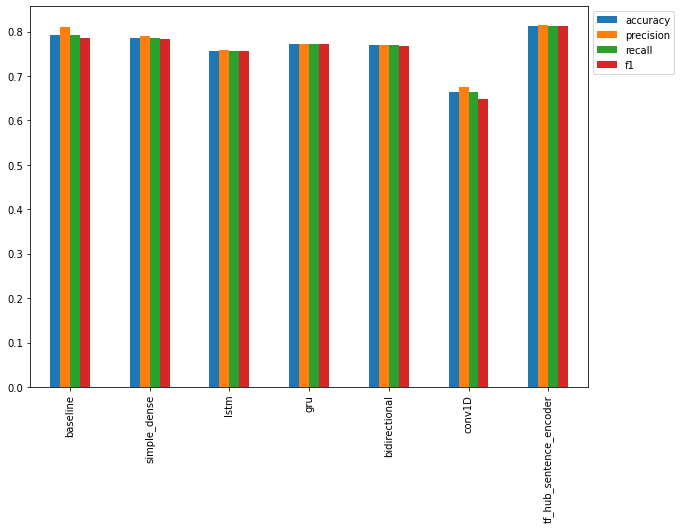

In [80]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

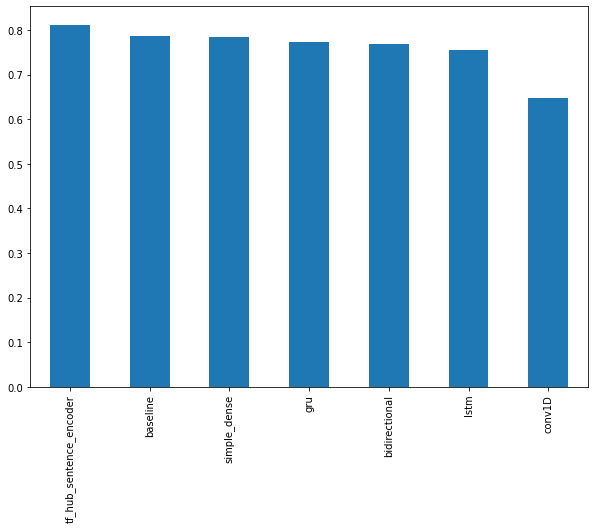

In [81]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

### Combining our models (model ensembling/stacking)

In [83]:
# Get mean and pred probs for 3 models
import numpy as np
baseline_pred_probs = np.max(model_0.predict_proba(X_val), axis=1)
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3)
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [84]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(y_val, combined_preds)
ensemble_results

{'accuracy': 78.4776902887139,
 'precision': 0.7844717878981898,
 'recall': 0.7847769028871391,
 'f1': 0.7843571338189964}

In [86]:
# Add our combined model's results to the results dataframe
all_model_results.loc["ensemble_results"] = ensemble_results 

In [87]:
# Convert the accuracy to the same scale as rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

In [88]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.786089,0.790328,0.786089,0.783297
lstm,0.757218,0.757781,0.757218,0.755472
gru,0.772966,0.772658,0.772966,0.772326
bidirectional,0.769029,0.769397,0.769029,0.767653
conv1D,0.664042,0.676491,0.664042,0.647388
tf_hub_sentence_encoder,0.813648,0.816066,0.813648,0.812062
ensemble_results,0.784777,0.784472,0.784777,0.784357


### Saving and loading a trained model

In [89]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [90]:
# Load model with custom hub layer (required wit HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [91]:
# How does our loaded model perform
loaded_model_6.evaluate(X_val, y_val)

24/24 [==============================] - 1s 21ms/step - loss: 0.4296 - Accuracy: 0.8136


[0.4296138882637024, 0.8136482834815979]

In [92]:
# Save TF Hub Sentence Encoder model to SavedModel format
model_6.save("Model_6_SavedModel_format")

In [93]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("Model_6_SavedModel_format")

In [94]:
# Evaluate the loaded saved model
loaded_model_6_SavedModel.evaluate(X_train, y_train)

215/215 [==============================] - 5s 18ms/step - loss: 0.3747 - Accuracy: 0.8383


[0.374650776386261, 0.8382717967033386]